In [4]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from glob import glob
import segmentation_models_pytorch as smp
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import ReduceLROnPlateau
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss
import matplotlib.pyplot as plt
import rasterio

In [5]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.3)
])


class InriaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, patch_size=512, transform=None):
        self.image_paths = sorted(glob(os.path.join(image_dir, '*.tif')))
        self.mask_paths = sorted(glob(os.path.join(mask_dir, '*.tif')))
        self.patch_size = patch_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        
        h, w, _ = image.shape
        ph, pw = self.patch_size, self.patch_size
        
        if h > ph and w > pw:
            y = np.random.randint(0, h - ph)
            x = np.random.randint(0, w - pw)
            image_patch = image[y:y+ph, x:x+pw]
            mask_patch = mask[y:y+ph, x:x+pw]
        else:
            image_patch = cv2.resize(image, (pw, ph), interpolation=cv2.INTER_LINEAR)
            mask_patch = cv2.resize(mask, (pw, ph), interpolation=cv2.INTER_NEAREST)

        mask_patch = (mask_patch == 255).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image_patch, mask=mask_patch)
            image_patch = augmented['image']
            mask_patch = augmented['mask']
            
        image_patch = image_patch.transpose(2, 0, 1) # HWC -> CHW
        image_tensor = torch.from_numpy(image_patch).float()
        mask_tensor = torch.from_numpy(mask_patch).unsqueeze(0).float() # Добавляем канал

        return image_tensor, mask_tensor

c:\Users\Alexander\AppData\Local\Programs\Python\Python313\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [6]:
from scipy.ndimage import distance_transform_edt as distance_transform

def one_hot_to_dist(seg: torch.Tensor) -> torch.Tensor:
    """
    Преобразует бинарную маску в карту евклидовых расстояний.
    """
    seg = seg.long().cpu().numpy()
    dist = torch.zeros_like(seg, dtype=torch.float32)
    for i in range(seg.shape[0]):
        pos_mask = 1 - seg[i]
        dist[i] = distance_transform(pos_mask)
        
    return dist


class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        """
        Комбинированная функция потерь с Boundary Loss.
        :param alpha: Вес DiceLoss. Вес FocalLoss будет (1-alpha).
        :param gamma: Вес BoundaryLoss относительно основной комбинации.
        """
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss(mode='binary', from_logits=True)
        self.focal_loss = FocalLoss(mode='binary')
        self.alpha = alpha

    def forward(self, y_pred, y_true):
        dice = self.dice_loss(y_pred, y_true)
        focal = self.focal_loss(y_pred, y_true)
        main_loss = self.alpha * dice + (1 - self.alpha) * focal
        return main_loss

In [7]:
def iou_metric(pred, target):
    pred = torch.sigmoid(pred) > 0.5
    target = target > 0.5
    intersection = (pred & target).float().sum((1, 2))
    union = (pred | target).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_IMG_DIR = './data/train/images/'
TRAIN_MASK_DIR = './data/train/gt/'
VAL_IMG_DIR = './data/val/images/'
VAL_MASK_DIR = './data/val/gt/'
LEARNING_RATE = 1e-4
BATCH_SIZE = 8
EPOCHS = 5


train_dataset = InriaDataset(
    image_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=train_transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

val_dataset = InriaDataset(VAL_IMG_DIR, VAL_MASK_DIR)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=1).to(DEVICE)

loss_fn = CombinedLoss(alpha=0.5)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=2)


best_iou = 0.0
best_epoch = 0


for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_iou = 0
    
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_iou += iou_metric(outputs, masks).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_train_iou = train_iou / len(train_loader)

    model.eval()
    val_loss = 0
    val_iou = 0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            
            val_loss += loss.item()
            val_iou += iou_metric(outputs, masks).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)
    scheduler.step(avg_val_loss)
    if avg_val_iou > best_iou:
        best_iou = avg_val_iou
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"🎉 Новая лучшая модель сохранена на эпохе {best_epoch} с Val IoU: {best_iou:.4f}")
    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train IoU: {avg_train_iou:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}")

Epoch 1/5 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


🎉 Новая лучшая модель сохранена на эпохе 1 с Val IoU: 0.3113
Epoch 1:
  Train Loss: 0.5096, Train IoU: 0.1201
  Val Loss: 0.9187, Val IoU: 0.3113


Epoch 2/5 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


🎉 Новая лучшая модель сохранена на эпохе 2 с Val IoU: 0.3818
Epoch 2:
  Train Loss: 0.4176, Train IoU: 0.2040
  Val Loss: 0.3767, Val IoU: 0.3818


Epoch 3/5 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


🎉 Новая лучшая модель сохранена на эпохе 3 с Val IoU: 0.4473
Epoch 3:
  Train Loss: 0.3998, Train IoU: 0.2465
  Val Loss: 0.3172, Val IoU: 0.4473


Epoch 4/5 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


🎉 Новая лучшая модель сохранена на эпохе 4 с Val IoU: 0.4864
Epoch 4:
  Train Loss: 0.3762, Train IoU: 0.4474
  Val Loss: 0.3175, Val IoU: 0.4864


Epoch 5/5 [Val]: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]

🎉 Новая лучшая модель сохранена на эпохе 5 с Val IoU: 0.5398
Epoch 5:
  Train Loss: 0.3680, Train IoU: 0.5703
  Val Loss: 0.2988, Val IoU: 0.5398


Модель ./best_model071.pth загружена на cuda
Изображение и маска загружены.


Sliding Window Inference: 100%|██████████| 10/10 [08:08<00:00, 48.84s/it]


Предсказание завершено.


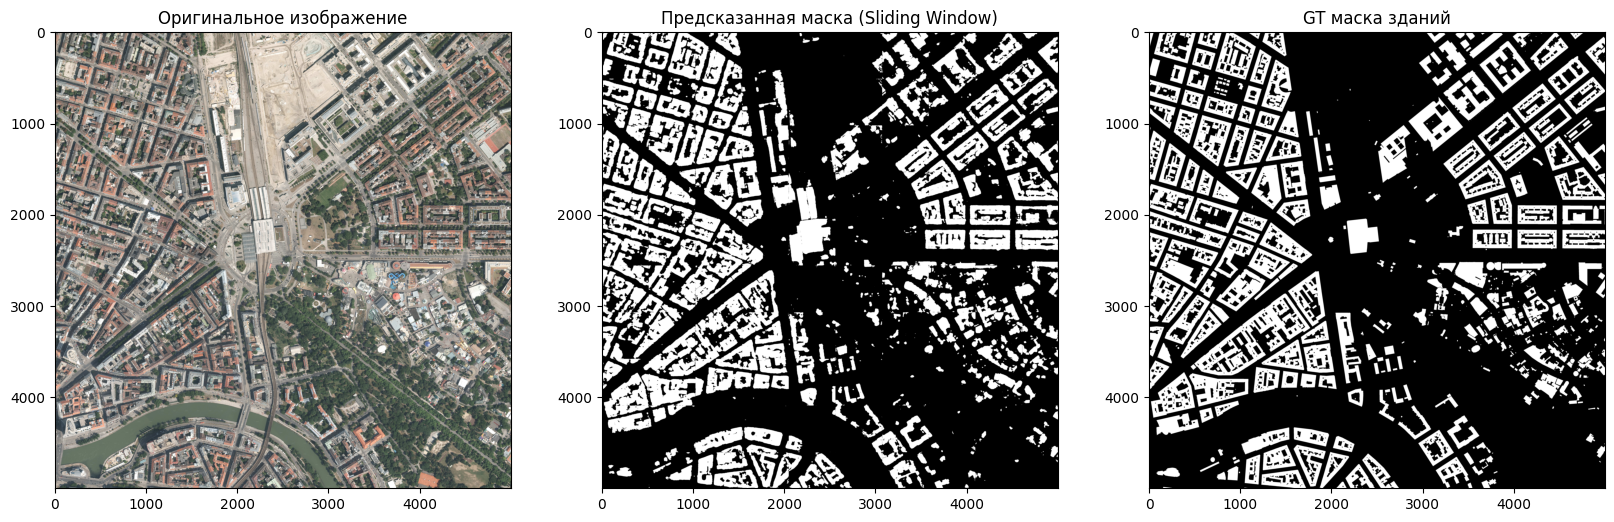

In [105]:
def predict_sliding_window(model, full_image, patch_size=512, stride=512, device='cpu'):
    """
    Делает предсказание для большого изображения с использованием скользящего окна.
    
    :param model: Обученная модель Pytorch.
    :param full_image: Изображение в формате numpy array (H, W, C).
    :param patch_size: Размер патча.
    :param stride: Шаг, с которым двигается окно. Меньше patch_size для перекрытия.
    :param device: Устройство для вычислений ('cuda' или 'cpu').
    :return: Финальная маска предсказаний (H, W).
    """
    model.eval()
    H, W, _ = full_image.shape
    
    full_image_float = full_image.astype(np.float32)
    
    prediction_map = np.zeros((H, W), dtype=np.float32)
    counts_map = np.zeros((H, W), dtype=np.float32)

    for y in tqdm(range(0, H, stride), desc="Sliding Window Inference"):
        for x in range(0, W, stride):
            y_end = min(y + patch_size, H)
            x_end = min(x + patch_size, W)
            
            patch = full_image_float[y:y_end, x:x_end]
            
            h_patch, w_patch, _ = patch.shape
            padded_patch = np.zeros((patch_size, patch_size, 3), dtype=np.float32)
            padded_patch[:h_patch, :w_patch] = patch
            
            input_tensor = torch.from_numpy(padded_patch.transpose(2, 0, 1)).float().unsqueeze(0).to(device)
            
            with torch.no_grad():
                output = model(input_tensor)
                pred_prob = torch.sigmoid(output).squeeze().cpu().numpy()
            
            prediction_map[y:y_end, x:x_end] += pred_prob[:h_patch, :w_patch]
            counts_map[y:y_end, x:x_end] += 1
            

    counts_map[counts_map == 0] = 1
    final_prediction = prediction_map / counts_map
    
    return final_prediction


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = './best_model071.pth'
TEST_IMAGE_PATH = './data/val/images/vienna11.tif'
TRUE_MASK_PATH = './data/val/gt/vienna11.tif'
PATCH_SIZE = 512  # Размер патча, на котором обучалась модель
STRIDE = 512      # Шаг окна.
THRESHOLD = 0.5   # Порог для бинаризации


model = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=1).to(DEVICE)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
print(f"Модель {MODEL_PATH} загружена на {DEVICE}")

full_image = cv2.imread(TEST_IMAGE_PATH)
full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)
true_mask = cv2.imread(TRUE_MASK_PATH)
print("Изображение и маска загружены.")


pred_mask_probabilities = predict_sliding_window(model, full_image, PATCH_SIZE, STRIDE, DEVICE)

pred_mask_binary = (pred_mask_probabilities > THRESHOLD).astype(np.uint8) * 255
print("Предсказание завершено.")

fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax[0].imshow(full_image)
ax[0].set_title('Оригинальное изображение')
ax[1].imshow(pred_mask_binary, cmap='gray')
ax[1].set_title('Предсказанная маска (Sliding Window)')
ax[2].imshow(true_mask)
ax[2].set_title('GT маска зданий')
plt.show()

In [107]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Вычисляет расстояние (в метрах) между двумя точками на Земле
    по их широтам и долготам.
    
    :param lat1, lon1: Широта и долгота первой точки (в градусах).
    :param lat2, lon2: Широта и долгота второй точки (в градусах).
    :return: Расстояние в метрах.
    """
    R = 6371000  # Радиус Земли в метрах
    
    phi1 = np.deg2rad(lat1)
    phi2 = np.deg2rad(lat2)
    delta_phi = np.deg2rad(lat2 - lat1)
    delta_lambda = np.deg2rad(lon2 - lon1)
    
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    
    return distance

def get_pixel_size_m2(tiff_path: str):
    with rasterio.open(tiff_path) as src:
        if not src.crs.is_geographic:
            transform = src.transform
            x_scale = transform.a
            y_scale = -transform.e
            if x_scale > 0 and y_scale > 0:
                pixel_area = x_scale * y_scale
                return pixel_area
    
        lon1, lat1, lon2, lat2 = src.bounds
        width = haversine_distance(lat1, lon1, lat1, lon2)
        height = haversine_distance(lat1, lon1, lat2, lon1)
        xscale = width/src.width
        yscale = height/src.height
        return xscale*yscale

In [108]:
TARGET_IMAGE_PATH = './data/val/gt/vienna11.tif'

scale = get_pixel_size_m2(TARGET_IMAGE_PATH)

scale

0.09

In [109]:
def calculate_building_area(pred_mask_binary, scale):
    return np.sum(pred_mask_binary)*scale

In [111]:
calculate_building_area(pred_mask_binary, scale)

np.float64(185322810.6)

In [112]:
calculate_building_area(true_mask, scale)

np.float64(515717620.2)

In [113]:
calculate_building_area(pred_mask_binary, scale)/calculate_building_area(true_mask, scale)

np.float64(0.35934938683718065)